# **Experiment Notebook**



In [2]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [3]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [4]:
# <Student to fill this section>
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor


In [5]:
# Import custom package
!pip install my_krml_25552249==2025.0.6.2

---
## A. Project Description


In [6]:
# <Student to fill this section>
student_name = "Shawya Saito"
student_id = "25552240"

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [8]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [9]:
# <Student to fill this section>
business_use_case_description = """
Explain clearly what is the goal of this project for the business.
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [11]:
# <Student to fill this section>
business_objectives = """
What will be the impact of accurate or incorrect results?
"""

In [12]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [13]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
How will the results be used?
Who will be the users of your predictions? Who will be impacted by your predictions?
"""

In [14]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [28]:
# Load training data
X_data = pd.read_csv('../../data/processed/X_data_clf.csv')
y_data = pd.read_csv('../../data/processed/y_data_clf.csv')

# Load test data
X_test = pd.read_csv('../../data/processed/X_test_clf.csv')
y_test = pd.read_csv('../../data/processed/y_test_clf.csv')

In [30]:
# Make date datetime dtype
X_data['date'] = pd.to_datetime(X_data['date'])

# Filter for more than 2019
mask = X_data['date'].dt.year >= 2019
X_data = X_data[mask]
y_data = y_data[mask]

### D.1 Approach "Correlation"


In [31]:
# Plot correlation matrix
numeric_cols = df_train.select_dtypes(include='number').columns.drop([target])
corr_matrix = df_train[numeric_cols.tolist() + [target]].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of all features")
plt.show()

NameError: name 'df_train' is not defined

Remove snowfall_sum as the values are all 0

In [ ]:
df_train.drop('snowfall_sum', axis=1, inplace=True)

In [ ]:
def correlation_filter(df, threshold=0.90):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop), to_drop

def vif_filter(df, thresh=10.0):
    variables = list(df.columns)
    dropped = []
    while True:
        vif = pd.Series(
            [variance_inflation_factor(df[variables].values, i) 
             for i in range(len(variables))],
            index=variables
        )
        max_vif = vif.max()
        if max_vif > thresh:
            drop_var = vif.idxmax()
            variables.remove(drop_var)
            dropped.append(drop_var)
        else:
            break
    return df[variables], dropped

In [ ]:
# Select numerical columns
numerical_cols = df_train.select_dtypes(include=[np.number]).columns

# Exclude the two target columns
feature_cols = [col for col in numerical_cols if col not in [target]]

X = df_train.copy()
X = X[feature_cols]

In [ ]:
# Correlation filtering
X_corr, dropped_corr = correlation_filter(X, threshold=0.90)
print("Dropped by correlation:", dropped_corr)

In [ ]:
X_corr.info()

In [ ]:
features = X_corr.columns.tolist() + ['weather_desc'] + [target]

df_fs = df_train.copy()
df_fs = df_fs[features]

In [ ]:
# <Student to fill this section>
feature_selection_1_insights = """
provide an explanation on why you use this approach for feature selection and describe its results
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "Correlation, Cramer's V and"


In [ ]:
from scipy.stats import pointbiserialr

# Select numeric features (excluding target)
numeric_features = df_fs.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [f for f in numeric_features if f != target]

# Compute point-biserial correlation with target
pb_corr = {}
for col in numeric_features:
    corr, pval = pointbiserialr(df_fs[col], df_fs[target])
    pb_corr[col] = corr

# Sort correlations
pb_corr = dict(sorted(pb_corr.items(), key=lambda x: abs(x[1]), reverse=True))

# Convert to DataFrame
pb_corr_df = pd.DataFrame(list(pb_corr.items()), columns=['Feature', 'Point-Biserial Correlation'])

# Display
pb_corr_df

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_num = df_clean[numeric_features]
y = df_clean[target]

mi_scores = mutual_info_classif(X_num, y, discrete_features=False)
pd.Series(mi_scores, index=X_num.columns).sort_values(ascending=False)

In [ ]:
def cramers_v(x, y):
    from scipy.stats import chi2_contingency
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print(cramers_v(df_clean['weather_desc'], df_clean['rain_in_7_days']))

In [ ]:
# <Student to fill this section>
feature_selection_2_insights = """
provide an explanation on why you use this approach for feature selection and describe its results
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

### D.n Approach "Random Forest Importance and RFE"

> You can add more cells related to other approaches in this section

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_fs.drop(columns=target).copy()
y = df_fs[target].copy()

categorical_cols = ['weather_desc']  
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
model = RandomForestClassifier(n_estimators=100, random_state=33)
model.fit(X_encoded, y)

importances = pd.Series(model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
print(importances)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=33)
rfe = RFE(model, n_features_to_select=8)
rfe.fit(X_encoded, y)

selected_features = X_encoded.columns[rfe.support_]
print(selected_features)

## D.z Final Selection of Features

In [32]:
# 
features_list = [
    "daylight_duration",
    "temperature_2m_mean",
    "wind_direction_10m_dominant",
    "wind_speed_10m_max",
    "relative_humidity_2m_max",
    "cloud_cover_mean",
    "pressure_msl_mean",
    "relative_humidity_2m_min",
    "shortwave_radiation_sum",
    "sunshine_duration"
]
target = 'rain_in_7_days'

In [33]:
# <Student to fill this section>
feature_selection_explanations = """
These features were chosen because they consistently ranked higher across RFE (model-driven selection), Random Forest importance (predictive power), and mutual information (non-linear dependence).
In contrast, features like precipitation lags and time components showed weak and inconsistent contribution across methods, so they were excluded."""

In [34]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [35]:
# <Student to fill this section>

In [36]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [38]:
# <Student to fill this section>

In [39]:
# <Student to fill this section>
feature_engineering_1_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

Here, we will save X_data, y_data, X_test and y_test with all potential variables for future experiments.

In [41]:
# Select the relevant features
X_data = X_data[features_list]
X_test = X_test[features_list]

In [42]:
# <Student to fill this section>
data_splitting_explanations = """
Provide some explanations on what is the best strategy to use for data splitting for this dataset
"""

In [43]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

---
## H. Save Datasets

> Do not change this code

In [44]:
# # Do not modify this code
# # Save training set
# try:
#   X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
#   y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

#   X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
#   y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

#   X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
#   y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
# except Exception as e:
#   print(e)

In [45]:
# # Do not modify this code
# # Save training set
# try:
#   X_data.to_csv('../../data/processed/X_data_clf.csv', index=False)
#   y_data.to_csv('../../data/processed/y_data_clf.csv', index=False)

#   X_test.to_csv('../../data/processed/X_test_clf.csv', index=False)
#   y_test.to_csv('../../data/processed/y_test_clf.csv', index=False)
# except Exception as e:
#   print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [46]:
# <Student to fill this section>

In [47]:
# <Student to fill this section>
performance_metrics_explanations = """
Provide some explanations on why you believe the performance metrics you chose is appropriate
"""

In [48]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [49]:
# <Student to fill this section>

In [50]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

In [51]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [52]:
# <Student to fill this section>

In [53]:
# # Choose last n years, e.g., 5
# n_years = 5
# recent_years = df['year'].unique()[-n_years:]  # last 5 years

# # Compute mean probability of rain for recent years
# recent_prob = df[df['year'].isin(recent_years)]['rain_in_7_days'].mean()
# print(f"Average rain probability for last {n_years} years: {recent_prob:.3f}")

In [54]:
# 

In [55]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from xgboost import XGBClassifier


tscv = TimeSeriesSplit(n_splits=5)

In [56]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 400, 25, dtype=int)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
}


In [57]:
def objective(params):
    aucs = []
    f1s = []
    for train_idx, val_idx in tscv.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        model = XGBClassifier(
            **params,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=33,
            early_stopping_rounds=20,
            class_weight='balanced'
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        preds_proba = model.predict_proba(X_val)[:, 1]

        f1_fold = f1_score(y_val, preds)
        auc_fold = roc_auc_score(y_val, preds_proba)

        f1s.append(f1_fold)
        aucs.append(auc_fold)

    return {
        'loss': -np.mean(aucs),  # maximize ROC-AUC
        'status': STATUS_OK,
        'fold_aucs': aucs,
        'fold_f1s': f1s,
        'mean_auc': np.mean(aucs),
        'mean_f1': np.mean(f1s)
    }

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(33)
)

100%|████████| 50/50 [00:10<00:00,  4.89trial/s, best loss: -0.6194310536053494]


In [166]:
def objective(params):
    aucs = []
    f1s = []
    for train_idx, val_idx in tscv.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        model = XGBClassifier(
            **params,
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=33,
            early_stopping_rounds=20
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        preds_proba = model.predict_proba(X_val)[:, 1]

        f1_fold = f1_score(y_val, preds)
        auc_fold = roc_auc_score(y_val, preds_proba)

        f1s.append(f1_fold)
        aucs.append(auc_fold)

    return {
        'loss': -np.mean(aucs),  # maximize ROC-AUC
        'status': STATUS_OK,
        'fold_aucs': aucs,
        'fold_f1s': f1s,
        'mean_auc': np.mean(aucs),
        'mean_f1': np.mean(f1s)
    }

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(33)
)

100%|████████| 50/50 [00:12<00:00,  4.01trial/s, best loss: -0.5627174139998807]


In [58]:
print("Best parameters:", best)

Best parameters: {'colsample_bytree': np.float64(0.6278269793309458), 'gamma': np.float64(0.18577653629598032), 'learning_rate': np.float64(0.1308870775151353), 'max_depth': np.int64(0), 'min_child_weight': np.int64(8), 'n_estimators': np.int64(7), 'subsample': np.float64(0.6789869370169918)}


In [ ]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [59]:
# Best parameters
best_params = {
    'max_depth': [2,3,4,5,6,7,8,9][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': [i for i in range(50,400,25)][best['n_estimators']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'min_child_weight': [i for i in range(1,10)][best['min_child_weight']],
}

final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=33,
    class_weight='balanced'
)

final_model.fit(X_data, y_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None,
              colsample_bytree=np.float64(0.6278269793309458), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.18577653629598032), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1308870775151353), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=225, n_jobs=None, ...)

In [173]:
# Best parameters
best_params = {
    'max_depth': [2,3,4,5,6,7,8,9][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': [i for i in range(50,400,25)][best['n_estimators']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'min_child_weight': [i for i in range(1,10)][best['min_child_weight']],
}

final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=33
)

final_model.fit(X_data, y_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.8579636179777163), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(0.0003510165108996238), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.013004212024325734), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, ...)

In [60]:
# Best trial index
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_trial = trials.trials[best_trial_idx]['result']

print("Fold-wise ROC-AUC:", best_trial['fold_aucs'])
print("Mean ROC-AUC:", best_trial['mean_auc'])
print("Fold-wise F1:", best_trial['fold_f1s'])
print("Mean F1:", best_trial['mean_f1'])

Fold-wise ROC-AUC: [np.float64(0.5847637117769051), np.float64(0.5932203389830508), np.float64(0.6793873312564902), np.float64(0.6086335048599201), np.float64(0.6311503811503811)]
Mean ROC-AUC: 0.6194310536053494
Fold-wise F1: [np.float64(0.6581632653061225), np.float64(0.7), np.float64(0.8159645232815964), np.float64(0.7729257641921398), np.float64(0.6555819477434679)]
Mean F1: 0.7205271001046654


In [174]:
# Best trial index
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_trial = trials.trials[best_trial_idx]['result']

print("Fold-wise ROC-AUC:", best_trial['fold_aucs'])
print("Mean ROC-AUC:", best_trial['mean_auc'])
print("Fold-wise F1:", best_trial['fold_f1s'])
print("Mean F1:", best_trial['mean_f1'])

Fold-wise ROC-AUC: [np.float64(0.5856578721455961), np.float64(0.6002427022333059), np.float64(0.6191908192327022), np.float64(0.585360836205938), np.float64(0.6447308284422207)]
Mean ROC-AUC: 0.6070366116519526
Fold-wise F1: [np.float64(0.5053763440860215), np.float64(0.4221879815100154), np.float64(0.5298507462686567), np.float64(0.5248407643312102), np.float64(0.6585612968591692)]
Mean F1: 0.5281634266110146


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [61]:
y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred))

Test Accuracy: 0.5893854748603352
Test F1: 0.6993865030674846
Test ROC-AUC: 0.5328632295141527


In [175]:
y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred))

Test Accuracy: 0.611731843575419
Test F1: 0.6729411764705883
Test ROC-AUC: 0.6009016745384285


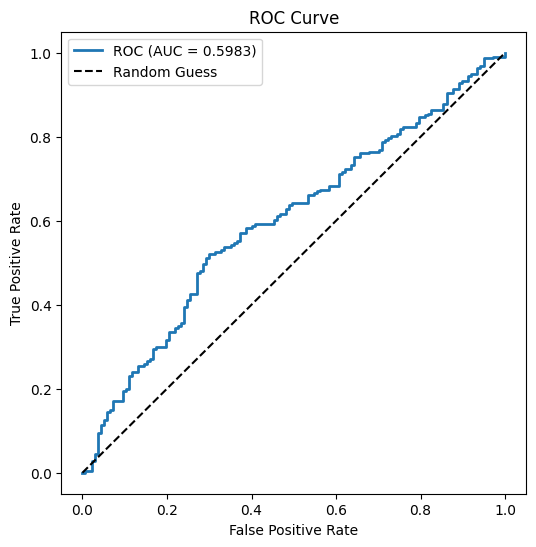

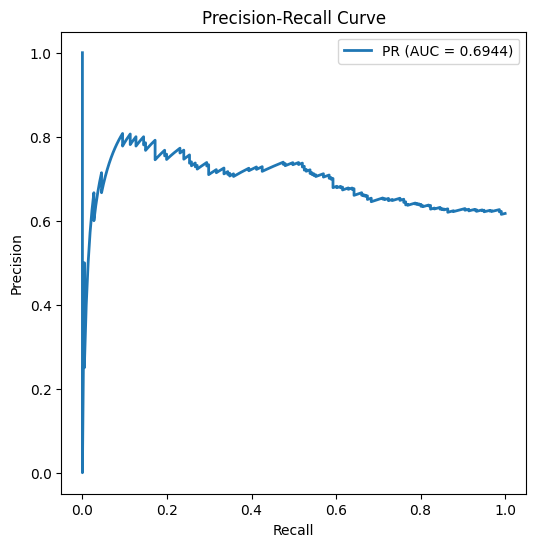

In [62]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc, plot_pr
# Get predicted probabilities for the positive class
y_probs = final_model.predict_proba(X_test)[:, 1]

plot_roc(y_test, y_probs)
plot_pr(y_test, y_probs)

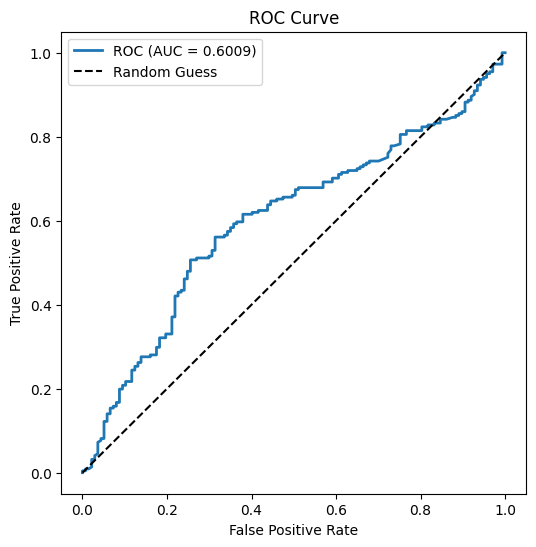

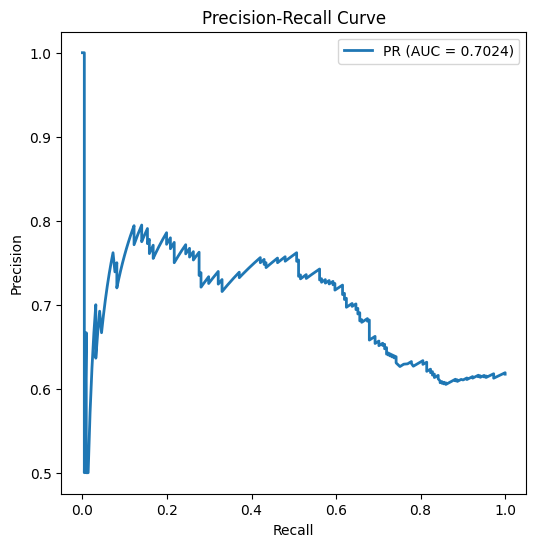

In [185]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc, plot_pr
# Get predicted probabilities for the positive class
y_probs = final_model.predict_proba(X_test)[:, 1]

plot_roc(y_test, y_probs)
plot_pr(y_test, y_probs)


Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.29      0.35       137
           1       0.64      0.77      0.70       221

    accuracy                           0.59       358
   macro avg       0.54      0.53      0.53       358
weighted avg       0.56      0.59      0.57       358



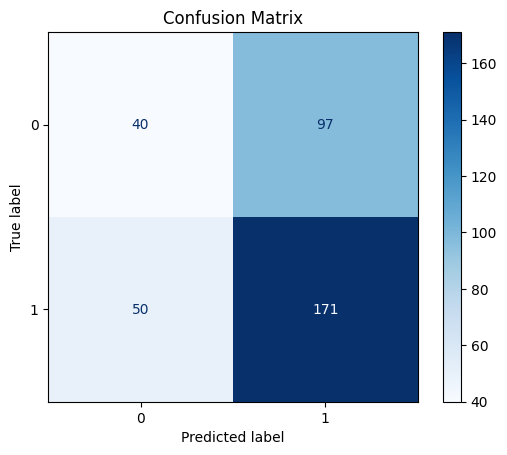

In [63]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred)

In [191]:
y_test.value_counts()

rain_in_7_days
1    221
0    137
Name: count, dtype: int64

In [141]:
# Predicted probabilities for positive class
y_probs = final_model.predict_proba(X_test)[:, 1]

# Candidate thresholds
thresholds = np.linspace(0, 1, 101)

# Compute weighted F1 for each threshold
weighted_f1_scores = [
    f1_score(y_test, (y_probs >= t).astype(int), average='weighted')
    for t in thresholds
]

# Find threshold that maximizes weighted F1
best_idx = np.argmax(weighted_f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for weighted F1:", best_threshold)
print("Weighted F1 at best threshold:", weighted_f1_scores[best_idx])

y_pred_wf1 = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold for weighted F1: 0.52
Weighted F1 at best threshold: 0.6196377665386907



Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.61      0.55       137
           1       0.72      0.62      0.66       221

    accuracy                           0.61       358
   macro avg       0.61      0.61      0.61       358
weighted avg       0.63      0.61      0.62       358



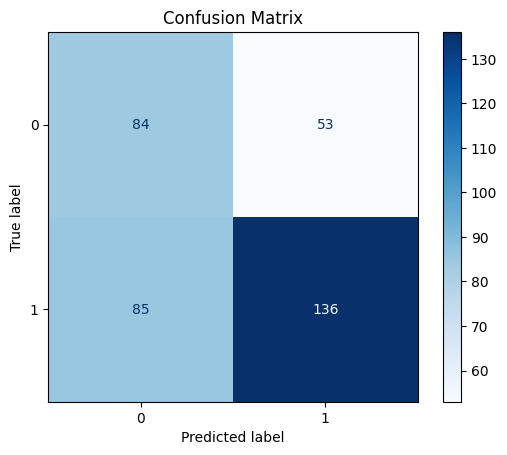

In [142]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_wf1)

In [131]:

y_probs = final_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 101)

f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for F1:", best_threshold)
y_pred_f1 = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold for F1: 0.0



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       137
           1       0.62      1.00      0.76       221

    accuracy                           0.62       358
   macro avg       0.31      0.50      0.38       358
weighted avg       0.38      0.62      0.47       358



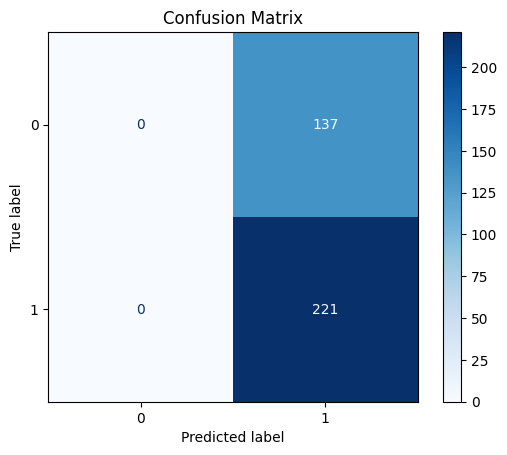

In [132]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_f1)

In [133]:
from sklearn.metrics import precision_recall_curve, auc

# Predicted probabilities
y_probs = final_model.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid division by 0

# Pick threshold with max F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold based on PR curve (max F1):", best_threshold)

# Optional: compute PR AUC
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

y_pred_pr = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold based on PR curve (max F1): 0.42903793
PR AUC: 0.7002600441151967



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       137
           1       0.62      1.00      0.76       221

    accuracy                           0.62       358
   macro avg       0.81      0.50      0.39       358
weighted avg       0.76      0.62      0.48       358



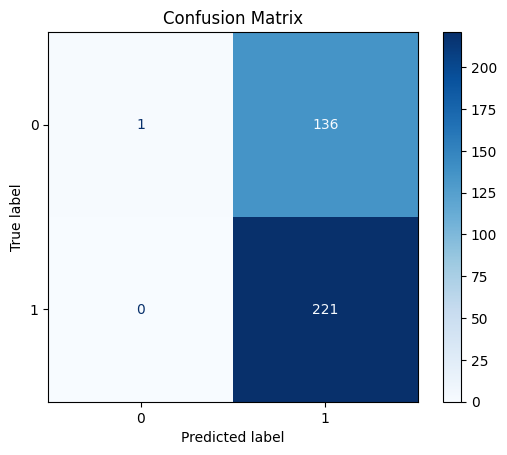

In [134]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_pr)

<Figure size 1000x600 with 0 Axes>

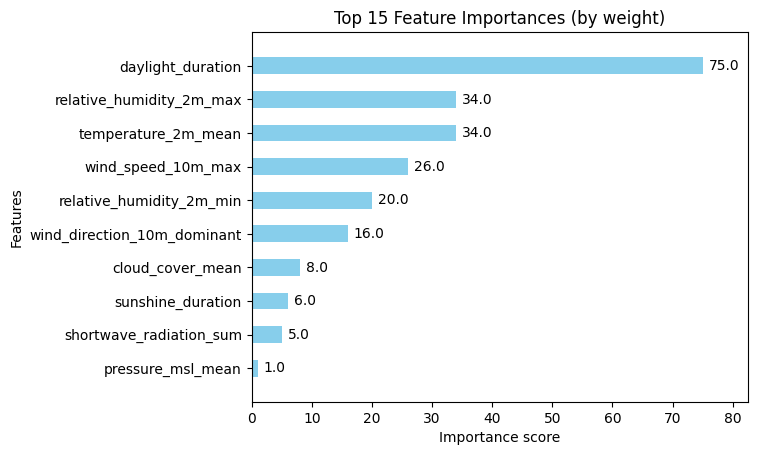

In [126]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming final_model is your trained XGBClassifier
# Plot feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=15, height=0.5, color='skyblue')
plt.title("Top 15 Feature Importances (by weight)")
plt.grid(False)
plt.show()

In [136]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1:", weighted_f1)

Weighted F1: 0.6153076465280577


#### Compare to baseline

In [139]:
# Find the most common class in training set
majority_class = y_data.mode()[0]
print("Majority class:", majority_class)

# Baseline predictions for test set
y_baseline = [majority_class] * len(y_test)

# F1 score
baseline_f1 = f1_score(y_test, y_baseline)
baseline_wf1 = f1_score(y_test, y_baseline, average='weighted')
print("Baseline F1 score:", baseline_f1)
print("Baseline weighted F1 score", baseline_wf1)

# ROC AUC
# For roc_auc_score, need predicted probabilities for the positive class
# Here we assign 1.0 if majority class is 1, else 0.0
if majority_class == 1:
    y_probs_baseline = [1] * len(y_test)
else:
    y_probs_baseline = [0] * len(y_test)

baseline_auc = roc_auc_score(y_test, y_probs_baseline)
print("Baseline ROC AUC:", baseline_auc)

Majority class: 1
Baseline F1 score: 0.7633851468048359
Baseline weighted F1 score 0.47125172470354393
Baseline ROC AUC: 0.5


In [ ]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# <Student to fill this section>

In [ ]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# <Student to fill this section>
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [ ]:
# <Student to fill this section>
experiment_results_explanations = """
Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
"""

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)